In [2]:
# 구글 드라이브의 폴더와 구글 코랩 폴더 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 현재 경로 확인
!pwd

/content


In [4]:
# drive/My Drive/Colab Notebooks 경로로 변경
%cd drive/My\ Drive/Colab\ Notebooks\

/content/drive/My Drive/Colab Notebooks


In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)

data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

## Image data

```python
이미지 데이터를 다룰 때는 주의 해야 할 것들이 있다 
1. 이미지 데이터의 크기가 재각각이다
2. 이미지 데이터를 머신러닝 데이터로 사용하기 위해서는 array data로 바꿔야한다 
3. 이미지 데이터를 파일로 갖고 있을 경우 tensorflow에서는 tf.io.read_file('')로 불러온다 
4. 불러온 이미지 파일 type에 따라서 decoder를 달리해야 한다 
5. png 파일은 투명도를 지원한다. 따라서 같은 크기더라도 채널 정보가 4차원이 된다 
```

## 이미지가 크기가 다를때 세 가지 해결 방식 

```python
1. resize 
- resize를 통해 크기를 통일시킨다 
- 단, resize를 하게 되면 데이터의 의미가 유지되지 않는다(이미지 왜곡이 발생한다)  
2. crop 
- 내가 생각한 이미지가 생각보다 클 때 사용한다
- 데이터를 일일이 crop 해야하는 단점이 있다 
3. padding 
- 내가 생각한 이미지가 생각보다 작을 때 사용한다 

# sppnet, r-cnn에서 resize관련 이슈를 해결한 방식을 배울 것이다 
```

## 이미지 데이터의 크기가 크면 클수록 좋을까?

```
# 가정: cpu, gpu의 성능은 최고라고 가정한다 => 데이터가 많으면 많을 수록 좋다 

데이터가 많다는 것은 2차원 데이터에서 row가 늘어나는 것이다 
row가 많으면 처리할 연산량이 많아지기 때문에 처리속도가 떨어진다 
하지만 하드웨어 성능관점에서 벗어나면 데이터의 row가 많으면 많을 수록 좋다 

그렇다면 column(feature/dimension)은 크면 클 수록 좋을까? => column은 i.i.d 가정을 갖고 있다 
예를 들어 꽃을 설명 할 때 꽃 잎 정보만 주어 졌을 때 정확하게 학습할까 아니면 꽃 잎 정보, 꽃 줄기 정보, 꽃의 씨앗 정보가 주어졌을 때 더 정확하게 학습할까? 
당연 더 많은 종류의 정보가 주어졌을 때 학습을 잘 할 수 있다 => 더 많은 nuance를 갖기 때문에 feature가 많은 것은 유리할 수 있다 
하지만, 차원이 증가하면 증가할 수록 차원의 저주가 발생한다 
즉, 차원이 증가함에 따라 필요한 데이터는 기하 급수적으로 늘어난다 

데이터에 따라, 모델에 따라, feature 갯수에 따라 데이터가 작으면 overfitting이 발생할 수 있다 
예를 들어 사람을 인식하는 모델이 있다고 가정했을 때 눈, 코, 입 정보만 주어진 데이터로 학습을 할 경우 
사람의 눈, 코, 입이 포함되어 있는 데이터의 경우는 정확하게 인식할 수 있지만 
눈, 코, 입과 더불어 사람의 몸 전체가 주어진 데이터에 대해서는 사람이라고 인식을 하지 못하게 될 수도 있다. 
뿐만 아니라 사람을 인식하는 모델을 학습할 때 사람 몸 전체에 대한 정보가 주어진 데이터를 학습하는데 
데이터에 대한 feature갯수 보다 데이터의 갯수가 적을 경우 학습된 사람 데이터에 대해서만 
정확하게 인식하고 조금이라도 다르게 생긴 사람 데이터 정보가 들어 왔을 때 정확히 인식하지 못할 가능성이 발생 할 수 있다  
```

## Feature selection

```
유의미한 feature만 추려서 사용한다 
```

```python
1. Filter (Statistics)
- 통계 값을 활용하여 클래스와 가장 밀접한 feature를 택한다 
- 상관성 분석을 통해 구분한다  
2. Wrapper 
- Algorithm + feature를 활용하여 최적의 feature를 택한다 
3. Embeded 
- Algorithm으로 자체만으로 feature의 중요도를 알려준다 
- Feature 기반의 분류를 할 수 있는 것에만 사용할 수 있다 

Feature selection은 한계가 있다

이미지 데이터는 i.i.d가 아니기 때문에 feature간의 독립성이 약해서 feature selection을 사용할 수 없다 
```

## Filter

In [ ]:
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2 # 카이제곱 검정: 관찰된 빈도가 기대되는 빈도와 의미있게 다른지의 여부를 검정하기 위해 사용되는 검정방법이다

In [ ]:
iris = sns.load_dataset('iris')
skb = SelectKBest(chi2, k=3) # 클래스와 연관성이 가장 큰 3가지 feature를 고른다 
skb.fit_transform(iris.iloc[:,:-1], iris.species) 

In [ ]:
skb.fit_transform(iris.iloc[:,:-1], iris.species)[:5]

array([[5.1, 1.4, 0.2],
       [4.9, 1.4, 0.2],
       [4.7, 1.3, 0.2],
       [4.6, 1.5, 0.2],
       [5. , 1.4, 0.2]])

In [ ]:
iris.iloc[:5] # sepal_length, petal_length, petal_width 3가지 feature가 선택되었다 

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
vars(skb)

{'k': 3,
 'pvalues_': array([4.47651499e-03, 1.56395980e-01, 5.53397228e-26, 2.75824965e-15]),
 'score_func': <function sklearn.feature_selection._univariate_selection.chi2>,
 'scores_': array([ 10.81782088,   3.7107283 , 116.31261309,  67.0483602 ])}

In [ ]:
skb.get_params()

{'k': 3,
 'score_func': <function sklearn.feature_selection._univariate_selection.chi2>}

In [ ]:
iris.corr() # petal_length, petal_width 두 가지 feature가 서로 연관되어 있기 때문에 둘 중 하나를 택한다 

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.117570,0.871754,0.817941
sepal_width,-0.117570,1.000000,-0.428440,-0.366126
petal_length,0.871754,-0.428440,1.000000,0.962865
petal_width,0.817941,-0.366126,0.962865,1.000000


## Wrapper

```
알고리즘과 데이터의 feature에 따른 경우의 수를 고려하여 계산하는 방식 
```

In [ ]:
from sklearn.feature_selection import RFE # Recursive feature extraction 
from sklearn.linear_model import LogisticRegression

rfe = RFE(LogisticRegression(), n_features_to_select=2) # 4개 중에 2개 선택 (iris feature가 4개 이기 때문에)
rfe.fit_transform(iris.iloc[:,:-1], iris.species) # fit_transform 
vars(rfe)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'estimator_': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'n_features_': 2,
 'n_features_to_select': 2,
 'ranking_': array([3, 2, 1, 1]),
 'step': 1,
 'support_': array([False, False,  True,  True]),
 'verbose': 0}

In [ ]:
iris.columns[:-1][rfe.support_] 

Index(['petal_length', 'petal_width'], dtype='object')

## Embeded

In [ ]:
from sklearn.tree import DecisionTreeClassifier # 분기를 시켜 feature의 중요도를 나타낸다 
from sklearn.ensemble import RandomForestClassifier

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(iris.iloc[:,:-1], iris.species)

dt.feature_importances_ # feature의 중요도를 알려준다 

array([0.01333333, 0.        , 0.56405596, 0.42261071])

In [ ]:
iris.iloc[:,:-1].columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')

In [ ]:
rf = RandomForestClassifier()
rf.fit(iris.iloc[:,:-1], iris.species)

rf.feature_importances_

array([0.10738656, 0.02592046, 0.41244991, 0.45424308])

## Dimension Reduction

```
차원 축소

nuance 손실도 발생하고 원본 데이터를 손상시킨다는 단점이 있다  
```

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(2) # 2차원으로 줄인다 

In [ ]:
pca.fit_transform(iris.iloc[:,:-1], iris.species) # 4차원 -> 2차원 / 공간이 왜곡 되었다 

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943],
       [-2.74534286, -0.31829898],
       [-2.72871654,  0.32675451],
       [-2.28085963,  0.74133045],
       [-2.82053775, -0.08946138],
       [-2.62614497,  0.16338496],
       [-2.88638273, -0.57831175],
       [-2.6727558 , -0.11377425],
       [-2.50694709,  0.6450689 ],
       [-2.61275523,  0.01472994],
       [-2.78610927, -0.235112  ],
       [-3.22380374, -0.51139459],
       [-2.64475039,  1.17876464],
       [-2.38603903,  1.33806233],
       [-2.62352788,  0.81067951],
       [-2.64829671,  0.31184914],
       [-2.19982032,  0.87283904],
       [-2.5879864 ,  0.51356031],
       [-2.31025622,  0.39134594],
       [-2.54370523,  0.43299606],
       [-3.21593942,  0.13346807],
       [-2.30273318,  0.09870885],
       [-2.35575405, -0.03728186],
       [-2.50666891, -0.14601688],
       [-2.46882007,  0.13095149],
       [-2.56231991,  0.36771886],
       [-2.63953472,

## Feature selection vs Dimension reduction

```
Feature selection은 데이터 값을 그대로 유지하면서 feature를 축소 했지만, 
Dimension reduction은 데이터 값을 변형하면서 차원을 축소 한다 => 공간을 왜곡시킨다 
```

In [ ]:
!pip install mglearn

     |████████████████████████████████| 540 kB 5.6 MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582637 sha256=b6566ae305251082dfd510a7030c15fc20744a4a49db3440e5d5f1900e8de59e
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


In [ ]:
import mglearn

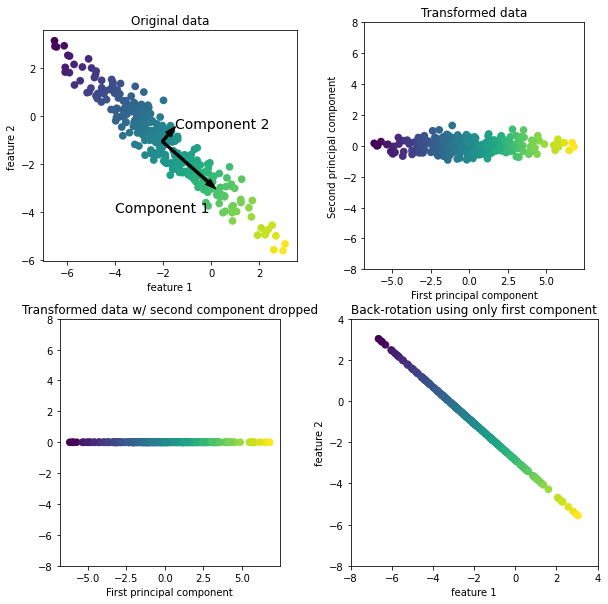

In [ ]:
mglearn.plot_pca.plot_pca_illustration() # 차원이 축소 되어도 의미를 잃지 않았다 / 고차원의 특성이 저차원에서도 유지가 되었다 / manifold

```
Manifold 

고차원의 데이터를 공간상에 표현하면 각 데이터들은 점의 형태로 찍혀지는데, 이러한 점들을 잘 아우르는 subspace를 manifold라고 한다 

```

## Path

In [8]:
import cv2
import os # 운영체제별로 결과가 상이할 수 있다 
from pathlib import Path # 운영체제 별로 상이하지 않게 범용적으로 사용 가능 

In [9]:
!pwd

/content/drive/My Drive/Colab Notebooks/고급시각반 정리


In [7]:
os.listdir('flower_photos/daisy')[:10]

['7410356270_9dff4d0e2e_n.jpg',
 '7568630428_8cf0fc16ff_n.jpg',
 '10770585085_4742b9dac3_n.jpg',
 '4286053334_a75541f20b_m.jpg',
 '8759177308_951790e00d_m.jpg',
 '4131565290_0585c4dd5a_n.jpg',
 '8710109684_e2c5ef6aeb_n.jpg',
 '3504430338_77d6a7fab4_n.jpg',
 '2612704455_efce1c2144_m.jpg',
 '8021540573_c56cf9070d_n.jpg']

In [8]:
path = 'flower_photos/daisy'
images = [cv2.imread(os.path.join(path,i)) for i in os.listdir(path)] # os.listdir : 특정 디렉토리를 리스트로 만들어 준다 

In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks/고급시각반 정리/flower_photos


In [10]:
path = Path('flower_photos/daisy') # path 객체로 불러온다 
images = [cv2.imread(str(i)) for i in path.iterdir()]

In [12]:
len(images)

633

## Pattern

```
path 객체는 pattern을 사용할 수 있다 
```

In [13]:
import glob # 패턴을 활용할 수 있는 패키지 

In [14]:
image = [cv2.imread(i) for i in glob.glob('flower_photos/daisy/*.jpg')] # glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다.

In [15]:
len(image)

633

In [13]:
import imageio

In [ ]:
imageio.volread(path) # s mode를 알아야 한다?

In [19]:
path = 'flower_photos/daisy'
imageio.mimread(path, format='jpg') # multiple image를 불러들일 수 있다. 단, jpeg는 multi-image 불러들일 수 없다 

RuntimeError: ignored

In [17]:
from skimage.io import imread_collection

In [18]:
imc = imread_collection('flower_photos/daisy/*.jpg')  # 패턴을 정확히 이해해야 한다 

In [20]:
imc.files[:10]

['flower_photos/daisy/5547758_eea9edfd54_n.jpg',
 'flower_photos/daisy/5673551_01d1ea993e_n.jpg',
 'flower_photos/daisy/5673728_71b8cb57eb.jpg',
 'flower_photos/daisy/5794835_d15905c7c8_n.jpg',
 'flower_photos/daisy/5794839_200acd910c_n.jpg',
 'flower_photos/daisy/11642632_1e7627a2cc.jpg',
 'flower_photos/daisy/15207766_fc2f1d692c_n.jpg',
 'flower_photos/daisy/21652746_cc379e0eea_m.jpg',
 'flower_photos/daisy/25360380_1a881a5648.jpg',
 'flower_photos/daisy/43474673_7bb4465a86.jpg']

In [22]:
w = os.walk('flower_photos/daisy')

In [29]:
for _, _, files in os.walk('flower_photos/daisy'):
  for i in range(10):
    print(files[i])

7410356270_9dff4d0e2e_n.jpg
7568630428_8cf0fc16ff_n.jpg
10770585085_4742b9dac3_n.jpg
4286053334_a75541f20b_m.jpg
8759177308_951790e00d_m.jpg
4131565290_0585c4dd5a_n.jpg
8710109684_e2c5ef6aeb_n.jpg
3504430338_77d6a7fab4_n.jpg
2612704455_efce1c2144_m.jpg
8021540573_c56cf9070d_n.jpg


In [1]:
import tensorflow as tf 

In [8]:
img = tf.keras.preprocessing.image_dataset_from_directory('flower_photos/')

Found 3670 files belonging to 5 classes.


In [10]:
type(img)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
for i in img:
  print(i[0].numpy()) # float형태로 한꺼번에 불러온다 단, 범용적으로 사용하지 못하는 단점이 있다 

## 전처리의 중요성 

```
전처리는 정답이 없다 
```

In [21]:
import tensorflow as tf 
import matplotlib.pyplot as plt

In [30]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

```
정 중앙에 있는 숫자 + 비틀림이 없는 숫자 + 크기가 일정 
- 이러한 가정이 있기 때문에 성능이 좋았다, 가정을 한 데이터에 대해서는 대표성을 잘 지닌다  
- 그러다 다양한 상황의 일반적인 데이터에는 성능이 좋지 못할 수도 있다 ex) A라는 사람의 필체를 학습한 a모델이 있다고 했을 때 A라는 사람의 글씨는 정확히 인식할 수 있지만 다른 사람의 필체는 정확하게 인식하지 못할 가능성이 높다 
```

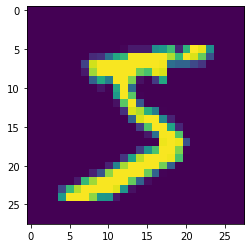

In [ ]:
plt.imshow(X_train[0]) # 정 중앙에 있는 숫자 + 비틀림이 없는 숫자 + 크기가 일정 (전처리를 통해서 새로운 데이터 분포를 만든 것) => 이러한 가정이 있기 때문에 성능이 좋았다, 가정을 한 데이터에 대해서는 대표성을 잘 지닌다  

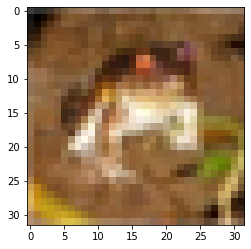

In [ ]:
plt.imshow(X_train[0]) # 3차원 데이터 이기 때문에 전통적인 머신러닝에 사용할 수 없다 

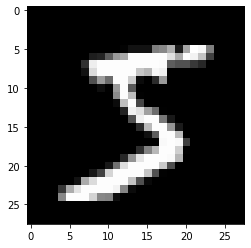

In [31]:
plt.imshow(X_train[0], cmap='gray') 

In [24]:
X_train[0].shape

(32, 32, 3)

In [25]:
X_train[0].flatten() # 1차원으로 변경, copy방식 => 원본하고 같이 바뀌고 싶지 않을 때

array([ 59,  62,  63, ..., 123,  92,  72], dtype=uint8)

In [26]:
X_train[0].ravel()   # 1차원으로 변경, view방식 => 원본하고 같이 바뀌고 싶을 때 

array([ 59,  62,  63, ..., 123,  92,  72], dtype=uint8)

```
color 이미지 일 때 (32, 32, 3) 이미지는 머신러닝 관점에서 차원은 3072(32X32X3)이다  
따라서 차원의 저주 문제가 발생한다 

gray로 바꿈으로써 차원을 축소할 수도 있다 => color를 gray로 바꿀 때 단순히 평균해서 바꾸기도 한다 => np.mean(X_train[0], axis=2)
```

In [28]:
from skimage.color import rgb2gray

In [29]:
X_train[0].size, rgb2gray(X_train[0]).size # nuance

(3072, 1024)

<table>
  <tr>
    <th>Raw data</th>
    <th>Featured data</th>
  </tr>
  <tr>
    <th>원본 데이터</th>
    <th>전처리된 데이터</th>
  </tr>
  <tr>
    <th>의미 손실이 없는 대신 패턴을 찾기 어렵다</th>
    <th>일부 의미가 손실 되지만 패턴을 찾기 좋다</th>
  </tr>
  <tr>
    <th>차원의 저주가 발생할 수 있다</th>
    <th>차원이 축소가 된다</th>
  </tr>
  <tr>
    <th>연산량이 많이 요구된다</th>
    <th>연산량이 많이 줄어든다</th>
  </tr>
  <tr>
    <th>저장 공간이 많이 요구된다</th>
    <th>저장 공간이 많이 줄어든다</th>
  </tr>
</table>

## 이미지 변화 적용(Filter) 

```
Filter도 전처리 방법중 하나 이다 
어떻게, 어떤 Filter를 적용하는 것이 맞는지 정확히 알 수 없다 
```

## Image augmentation

```
원본 이미지의 의미를 유지시키면서 변형 하고 
새로운 데이터 셋으로 사용 한다 
```

In [33]:
from sklearn.datasets import load_digits

In [34]:
data = load_digits()

In [35]:
data.images.shape

(1797, 8, 8)

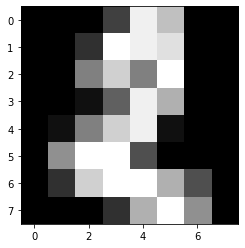

In [36]:
plt.imshow(data.images[2], cmap='gray')

In [37]:
data.data # 하나의 데이터는 1차원으로 변경되었다 

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

## Model

```
이미지 데이터는 공통적으로 Non Linear다 
Non Linear라는 것은 데이터 셋을 비선형적으로 구분해야 한다  
```

```
머신러닝은 meta 프로그래밍이 가능하다 => 메타 프로그래밍은 자기 자신 혹은 다른 컴퓨터 프로그램을 데이터로 취급하며 프로그램을 작성·수정하는 것을 말한다
특징들이 일반적이기 때문에 (abstract)
```

In [38]:
import cv2
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [39]:
dt = DecisionTreeClassifier() # 1단계 (Hyperparameter)

In [40]:
dt.fit(data.data, data.target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [41]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier

In [42]:
t = cross_val_score(dt, data.data, data.target, cv = 10) 

In [43]:
t

array([0.79444444, 0.86666667, 0.85      , 0.8       , 0.78333333,
       0.87222222, 0.90555556, 0.81005587, 0.81564246, 0.82681564])

In [44]:
t.mean() # 전처리가 잘 되어 있기 때문에 성능이 좋다 

0.8324736188702669

In [45]:
data.data = data.data.astype('float32')
knn1 = cv2.ml.KNearest_create()
knn1.train(data.data, cv2.ml.ROW_SAMPLE ,data.target) # 데이터가 연속이라는 가정을 두고 학습을 해야 하기 때문에 데이터 타입이 float이어야 한다 

True

In [46]:
knn2 = KNeighborsClassifier()
knn2.fit(data.data, data.target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [47]:
knn1.findNearest(data.data[3][np.newaxis], 3) # 2차원 데이터를 받는다 

(3.0,
 array([[3.]], dtype=float32),
 array([[3., 3., 3.]], dtype=float32),
 array([[  0., 197., 232.]], dtype=float32))

In [48]:
knn2.predict(data.data[3][np.newaxis])

array([3])

In [49]:
%timeit knn1.findNearest(data.data, 5) 

10 loops, best of 5: 148 ms per loop


In [50]:
%timeit knn2.predict(data.data) 

1 loop, best of 5: 417 ms per loop
